In [1]:
%load_ext autoreload
%autoreload 2

PRETRAINED_MODEL="bert-base-uncased"
TASKS=["cola", "mnli", "qnli", "qqp"]

##  Load Pretrained Model 

Code for loading a pretrained BERT checkpoint

In [2]:
from transformers import BertForSequenceClassification

## Load Dataset

Loads the dataset for GLUE task

In [3]:
from datasets import load_dataset
from transformers import BertTokenizerFast

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)

datasets = {}
for task in TASKS:
    datasets[task] = load_dataset('glue', task)

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset glue (/home/pfernand/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
from transformers import DataCollatorWithPadding

def tokenize_function(examples, task, max_seq_length=512):
    # Tokenize the texts
    sentence1_key, sentence2_key = task_to_keys[task]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    return tokenizer(*args, max_length=max_seq_length, truncation=True)

tokenized_datasets = {}
for task in TASKS:
    tokenized_datasets[task] = datasets[task].map(lambda e: tokenize_function(e, task=task), batched=True)
    
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-00d4e52ed0260979.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-148da28a48267e58.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-4dc0e479369f30b1.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-d70a88ec7568adce.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-e091473a8e1dff94.arrow
Loading cached processed dataset at /home/pfernand/.cac

  0%|          | 0/10 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-1ce958ae7c6af66a.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-466dfb2328954e24.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-fa2e2bb403e7971d.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-3270a394d26a48c1.arrow
Loading cached processed dataset at /home/pfernand/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-e8ee6c0f300dee35.arrow
Loading cached processed dataset at /home/pfernand/.cach

## Finetune

In [5]:
from datasets import load_metric
import numpy as np

metrics = {task: load_metric("glue", task) for task in TASKS}

def compute_metrics(p, task):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    result = metrics[task].compute(predictions=preds, references=p.label_ids)
    if len(result) > 1:
        result["combined_score"] = np.mean(list(result.values())).item()
    return result

In [ ]:
from transformers import Trainer, TrainingArguments
import torch

for task in TASKS:
    num_labels=len(datasets[task]["train"].features["label"].names)
    finetuned_path = f"{PRETRAINED_MODEL}-ft-{task}"
    model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=num_labels)
    
    training_args = TrainingArguments(
        output_dir = finetuned_path, 
        evaluation_strategy="epoch",
        save_strategy="no",
    )

    trainer = Trainer(
        model,
        training_args,
        train_dataset=tokenized_datasets[task]["train"],
        eval_dataset=tokenized_datasets[task]["validation_matched" if task == "mnli" else "validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, task=task)
    )

    trainer.train()

    model.save_pretrained(finetuned_path)
    del model
    del trainer

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss


{'label': 2, 'idx': 100, 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'hypothesis': 'The exhibition only displays cars from the 2000s.', 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'premise': 'It displays all kinds of vehicles, from the coach that carried Napoleon to and from Moscow in 1812 to a splendid 4-horsepower Renault car from 1904 and other turn-of-the-century classics.', 'input_ids': [101, 2009, 8834, 2035, 7957, 1997, 4683, 1010, 2013, 1996, 2873, 2008, 3344, 8891, 2000, 1998, 2013, 4924, 1999, 9842, 2000, 1037, 21459, 1018, 1011, 15149, 14605, 2482, 2013, 5692, 1998, 2060, 2735, 1011, 1997, 1011, 1996, 1011, 2301, 10002, 1012, 102, 1996, 4538, 2069, 8834, 3765, 2013, 1996, 8876, 1012, 102]}


## Evaluating on Squad

Code for running evaluation on finetuned model on squad

In [26]:
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments

for task in TASKS:
    finetuned_path = f"{PRETRAINED_MODEL}-ft-{task}"
    model = BertForSequenceClassification.from_pretrained(finetuned_path)
    tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL)
    val_key = "validation_matched" if task == "mnli" else "validation"

    eval_args = TrainingArguments(
        output_dir = finetuned_path,
        do_train = False,
        do_predict = True,
        dataloader_drop_last = False,
    )

    trainer = Trainer(
        model,
        eval_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(task=task)
    )
    start = timer()
    metrics = trainer.evaluate(eval_dataset=tokenized_datasets[task][val_key])
    end = timer()
    delta = end-start
    print(task)
    print(metrics)
    print(f"time per sample = {delta/len(tokenized_datasets[val_key])}")

loading configuration file bert-small-cola/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file bert-small-cola/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model ch

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 8


{'eval_loss': 1.118129014968872, 'eval_matthews_correlation': 0.32394179731057016, 'eval_runtime': 0.9511, 'eval_samples_per_second': 1096.671, 'eval_steps_per_second': 137.741}


In [26]:
import numpy as np
from datasets import load_metric
from timeit import default_timer as timer

start = timer()
outputs = trainer.predict(tokenized_datasets["test"].remove_columns("label"))
end = timer()
delta = end-start
metric = load_metric("glue", TASK)
predictions = np.argmax(outputs.predictions, axis=-1)
metric.compute(predictions=predictions, references=outputs.label_ids)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence.
***** Running Prediction *****
  Num examples = 1063
  Batch size = 8


RuntimeError: cuda runtime error (710) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1634272172048/work/aten/src/THC/THCCachingHostAllocator.cpp:280

In [61]:
print(f"time per sample = {delta/len(tokenized_datasets['test'])}")

time per sample = 0.012398742895655205


## Divide Checkpoint

Code for dividing a checkpoint by layer

In [7]:
model.save_pretrained("ft-bert-base-uncased")

In [8]:
from checkpoint_divider import divide_checkpoint

divide_checkpoint("ft-bert-base-uncased/pytorch_model.bin", divided_checkpoint)

## Load Divided Checkpoint

In [3]:
def get_current_memory():
    import os, psutil
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

In [6]:
import torch

print(torch.load(f"{divided_checkpoint}/layer2keys.bin"))
layers=[]
memory=[]
for layer in range(14):
    layers.append(torch.load(f"{divided_checkpoint}/pytorch_model_{layer}.bin"))
    memory.append(get_current_memory())

defaultdict(<class 'list'>, {0: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.position_ids', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight'], 1: ['bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.enco

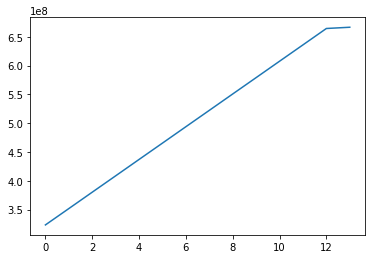

In [5]:
import matplotlib.pyplot as plt

plt.plot(memory)